#### testing Ming et al 2005 parameterization

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from scipy.ndimage import uniform_filter1d
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae
from PySDM.physics import si

from PySDM_examples.Ming_et_al_2005.aerosol import CONSTANTS_MING, AerosolMingSM, AerosolMingTM
from PySDM_examples.Ming_et_al_2005.run_Ming_parcel import run_parcel

from PySDM.initialisation.sampling.spectral_sampling import Logarithmic
from PySDM_examples.Ming_et_al_2005.parameterization import solve_smax, droplet_number_conc

In [3]:
n_sd_per_mode = 20

w = np.array([0.03, 0.1, 0.5, 1.0, 5.0, 10.0]) * si.m / si.s
AF_S = np.zeros((2,len(w)))
AF_V = np.zeros((2,len(w)))
AFerror = np.zeros(len(w))
s_max = np.zeros(len(w))

formulae = Formulae(constants=CONSTANTS_MING)
const = formulae.constants
aerosol = AerosolMingSM(
        water_molar_volume=const.Mv / const.rho_w,
        N=200 / si.cm**3, D=0.02 * si.um, sig=2.5,
    )
T_init = 283
p_init = 800e2

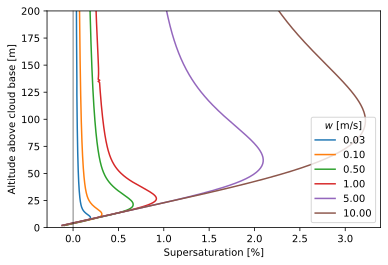

HTML(value="<a href='./fig_supersaturation_nsd_20.pdf' target='_blank'>./fig_supersaturation_nsd_20.pdf</a><br…

In [4]:
for i,wi in enumerate(w):
    output = run_parcel(formulae, wi, aerosol, n_sd_per_mode, 
        RH0=0.998, T0=T_init * si.K, p0=p_init * si.Pa, z_max = 200 * si.m)
    
    AF_S[:,i] = output.activated_fraction_S
    AF_V[:,i] = output.activated_fraction_V
    AFerror[i] = output.error[0]
    s_max[i] = np.nanmax(np.array(output.profile["smax"]))
    pyplot.plot(np.array(output.profile["smax"])*100., output.profile["z"], label=f"{wi:.02f}")
pyplot.axvline(0, color="k", lw=0.5)
pyplot.xlabel("Supersaturation [%]")
pyplot.ylabel("Altitude above cloud base [m]")
pyplot.ylim(0,200)
pyplot.legend(title=r"$w$ [m/s]")
show_plot(f"fig_supersaturation_nsd_{n_sd_per_mode}.pdf")

# pyplot.step(Rj[:-1] / si.nm, uniform_filter1d(Nj, size=1), where='pre')
# pyplot.xscale("log")
# pyplot.yscale("log")
# pyplot.show()

In [5]:
Rj, Nj = [], []
for m in aerosol.modes:
    rj, nj = Logarithmic(m['spectrum']).sample(100)
    Rj.append(rj)
    Nj.append(nj)
Rj = np.concatenate(Rj, axis=0)
Nj = np.concatenate(Nj, axis=0)
# pyplot.loglog(Rj, Nj, "ko-")
# pyplot.show()

param_w = np.geomspace(0.03, 10, num=20)
param_s_max = np.zeros(len(param_w))
param_AF = np.zeros(len(param_w))

for i,wi in enumerate(param_w):
    smax = solve_smax(wi, T_init, p_init, Rj, Nj)
    CDNC = droplet_number_conc(Rj, Nj, smax, T_init) # 1/m3
    param_s_max[i] = smax
    param_AF[i] = CDNC / np.sum(Nj)

/Users/claresinger/Research/PySDM/examples/PySDM_examples/Ming_et_al_2005/parameterization.py:71: RuntimeWarning: invalid value encountered in double_scalars
  return (acrit(T, ns)**2 + G(acrit(T, ns), T, p) * (smax**k - seq(acrit(T,ns), T, ns)**k) / (alpha(T) * w))**(1/2)


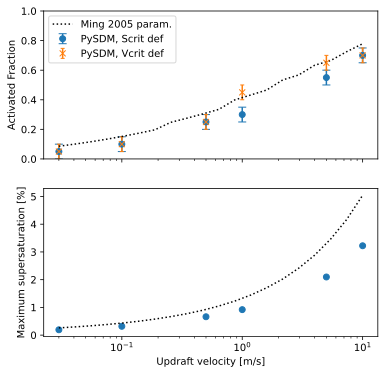

HTML(value="<a href='./fig_nsd_20.pdf' target='_blank'>./fig_nsd_20.pdf</a><br>")

In [6]:
fig, axes = pyplot.subplots(2, 1, sharex=True, figsize=(6,6))

ax = axes[0]
ax.errorbar(w * si.m / si.s, AF_S[0,:], yerr=AFerror, fmt='o', capsize=4, label="PySDM, Scrit def")
ax.errorbar(w * si.m / si.s, AF_V[0,:], yerr=AFerror, fmt='x', capsize=2, label="PySDM, Vcrit def")
ax.plot(param_w * si.m / si.s, param_AF, "k:", label="Ming 2005 param.")
ax.set_ylabel('Activated Fraction')
ax.set_ylim(0,1)
ax.legend(loc="best")

ax = axes[1]
ax.plot(w * si.m / si.s, s_max * 100, "o")
ax.plot(param_w * si.m / si.s, param_s_max * 100, "k:")
ax.set_xscale('log')
ax.set_xlabel('Updraft velocity [m/s]')
ax.set_ylabel('Maximum supersaturation [%]')
show_plot(f"fig_nsd_{n_sd_per_mode}.pdf")